# Matching PSF sims to in-flight JWST data

In [1]:
import webbpsf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy, astropy.io.fits as fits

Often one wants to generate PSFs matched to some particular science dataset or file. The convenience function `webbpsf.setup_sim_to_match_data` helps with this, using the file's FITS header to set up a simulated instrument matched to the appropriate instrument setup and date of observation.  

In [2]:
filename = 'jw02739010001_02103_00001_nrcalong_cal.fits'

In [3]:
inst = webbpsf.setup_sim_to_match_file(filename)

Setting up sim to match jw02739010001_02103_00001_nrcalong_cal.fits
iterating query, tdelta=3.0

MAST OPD query around UTC: 2023-04-05T03:33:47.591
                        MJD: 60039.14846748843

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2023040302-NRCA3_FP1-1.fits
	Date (MJD):	 60037.0387
	Delta time:	 -2.1098 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2023040504-NRCA3_FP1-1.fits
	Date (MJD):	 60039.4669
	Delta time:	 0.3184 days
User requested choosing OPD time closest in time to 2023-04-05T03:33:47.591, which is R2023040504-NRCA3_FP1-1.fits, delta time 0.318 days
Importing and format-converting OPD from /Users/mperrin/software/webbpsf-data/MAST_JWST_WSS_OPDs/R2023040504-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F335M
    Detector: NRCA5
    Apername: NRCA5_FULL
    Det. Pos.: (1024, 1024) 
    Imag

This function will:
 * Create a webbpsf instrument object for the relevant instrument
 * Configure it to have the correct filter, detector, and other relevant instrument parameters for that science data file (e.g. coronagraph masks and so on). 
 * Load the measured telescope mirror alignment data from the closest-in-time wavefront sensing visit to that science data. 

## A reminder about output data products

Recall that the output data files from a simulated PSF are multi-extension FITS, containing both oversampled and detector-sampled outputs, and with and without added distortion effects. In general there will be 4 output FITS HDUs:

In [4]:
psf = inst.calc_psf()
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     116   (316, 316)   float64   
  1  DET_SAMP      1 ImageHDU       118   (79, 79)   float64   
  2  OVERDIST      1 ImageHDU       170   (316, 316)   float64   
  3  DET_DIST      1 ImageHDU       171   (79, 79)   float64   


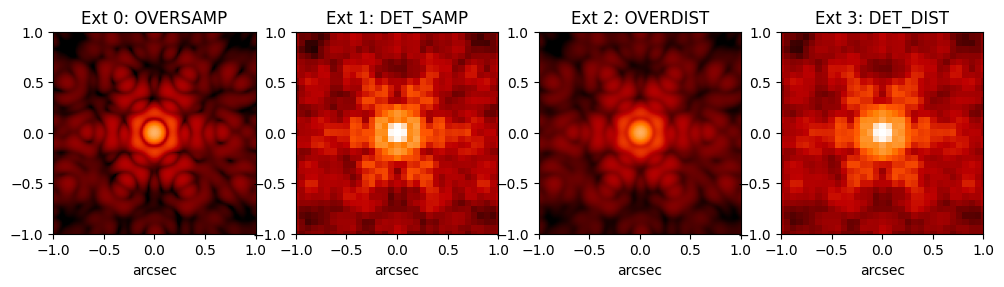

In [5]:
fig, axes = plt.subplots(figsize=(12,3), ncols=4)
for i in range(len(psf)):
    webbpsf.display_psf(psf, ext=i, ax=axes[i], title=f'Ext {i}: {psf[i].header["EXTNAME"]}',
                       imagecrop=2, colorbar=False)

The difference between the oversampled and detector-sampled output products is fairly obvious. The distortion effects are generally more subtle: 
 * In this example case, note the slightly blurred softer look of the DET_DIST output compared to DET_SAMP, or of OVERDIST compared to OVERSAMP. This aspect of the simulation is a model for charge transfer physics and inter-pixel capacitance within the detector which result in crosstalk between adjacent pixels.
 * Also included as part of the distortion is a model for optical geometric distortions (including for instance slight differences between X and Y pixel scales, small rotations and skews of the detector pixel axes, the very-slightly-different position angles for each NIRCam detector, etc.). This attempts to forward-model the distortions which the "drizzle" pipeline algorithm corrects for, using the same astrometric calibration information for the instruments recorded in the [science instrument aperture file](https://pysiaf.readthedocs.io/en/latest/). 

**In general it is this last extension 3, DET_DIST, that is expected to have the greatest fidelity to measured PSFs observed in detector coordinates, such as in `rate.fits` or `cal.fits` pipeline data products.** Users are encouraged to use this part of the PSF sim output in most cases. Note, JWST has many instrument modes, and the precise level of fidelity achieved compared to observed PSFs varies depending on instrument and mode. 

## Understanding and matching positions on the detector

### Adjusting the position of the simulated subarray

You can think of the simulation output as a model for a PSF on a *particular subarray* within the pixels in a given detector or image. 
There are small but nonzero variations in PSFs across the field of view of each instrument, and WebbPSF includes models and calibration data that allow simulating this position dependence. 

By default, the PSF calculation is configured for the center of the selected detector, which will often give a reasonable match to PSFs across the detector. This may be sufficient for many use cases, depending on the particular science needs. 

If you have a particular detector region of interest, and want to include the subtle small dependence on position, simply adjust the `detector_position` attribute. This attribute sets which *pixel on the image* corresponds to the *center pixel location of the subarray of pixels output by webbpsf*.  

(Note, for science images taken using a detector subarray instead of the full detector, after using `setup_sim_to_match_data` the `detector_pixel` coordinates will refer to the *pixel coordinates in that subarray* only, not the full detector. In other words, simply set `detector_pixel` to the desired (X,Y) coordinates within the specified science image, and it will work correctly for either full-frame or subarray science data).

In [6]:
psf_center = (1996, 1413)  # note this is in X, Y order
boxsize = 50

In [7]:
inst.detector_position = psf_center

In [8]:
sim_psf = inst.calc_psf(fov_pixels=boxsize)

In [9]:
# Load science data. Extract the surface brightness and uncertainty for the desired subarray
obs_im = fits.open(filename)

obs_psf = astropy.nddata.Cutout2D(obs_im['SCI'].data, position=psf_center, size=boxsize).data
obs_psf -= np.nanmedian(obs_psf) # simple background subtraction

obs_psf_err = astropy.nddata.Cutout2D(obs_im['ERR'].data, position=psf_center, size=boxsize).data

In [10]:
# Define a convenience function for comparisons to use here

def plot_data_sim_comparison(obs_psf, obs_psf_err, sim_psf):
    fig, axes = plt.subplots(figsize=(13,3), ncols=3)

    vmax = np.nanmax(obs_psf)
    cmap = matplotlib.cm.gist_heat
    cmap.set_bad(cmap(0))
    axes[0].imshow(obs_psf, 
                   norm = matplotlib.colors.LogNorm(vmax/1e4, vmax), 
                   cmap=cmap, origin='lower')
    axes[0].set_title("Observed PSF from science data")

    webbpsf.display_psf(sim_psf, ext='DET_DIST', vmax=0.1, vmin=1e-5, ax=axes[1], )
    
    scalefactor = np.nansum(obs_psf)
    difference = obs_psf - sim_psf["DET_DIST"].data *scalefactor
    axes[2].imshow(difference, 
                   norm = matplotlib.colors.LogNorm(vmax/1e5, vmax), 
                   cmap=cmap, origin='lower')
    # compute a simple goodness-of-fit metric 
    chisqr = np.nansum(difference**2/obs_psf_err**2)/np.isfinite(difference).sum()
    axes[2].set_title("Difference")
    axes[2].text(3, 3, f"$\chi^2$ = {chisqr:.2f}", color='white') 
    for ax in [axes[0], axes[2]]:
        ax.set_xlabel("Pixels")
        ax.axvline((boxsize-1)/2, ls=":", alpha=0.75)
        ax.axhline((boxsize-1)/2, ls=":", alpha=0.75)


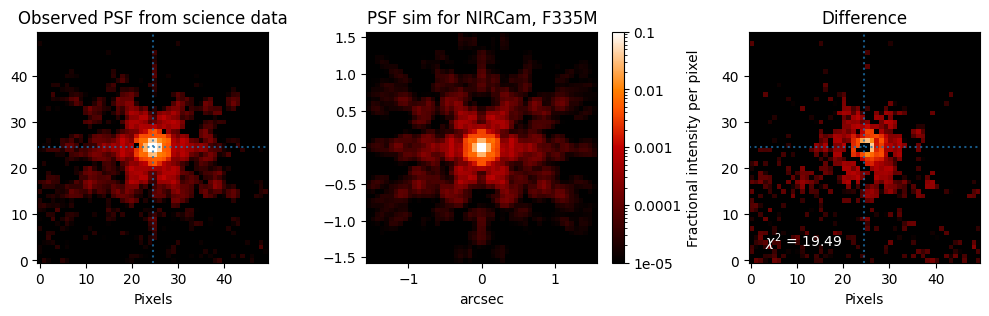

In [11]:
plot_data_sim_comparison(obs_psf, obs_psf_err, sim_psf)

### Adjusting the position of the simulated point source

By default the PSF will be exactly centered in that output grid of pixels. You may think of this as simulating a star that is precisely centered in that subarray of pixels on the detector. 

To adjust the position of that point source, including for subpixel positions, you can set `options['source_offset_{x/y}']`. These allow you to specify an angular offset in arcseconds. 

In [12]:
inst.options['source_offset_x'] = 0.010   # in units of arcseconds. So, this is about 1/5 of a NRC LW pixel
inst.options['source_offset_y'] = 0.005

In [13]:
sim_psf_offset = inst.calc_psf(fov_pixels=boxsize)

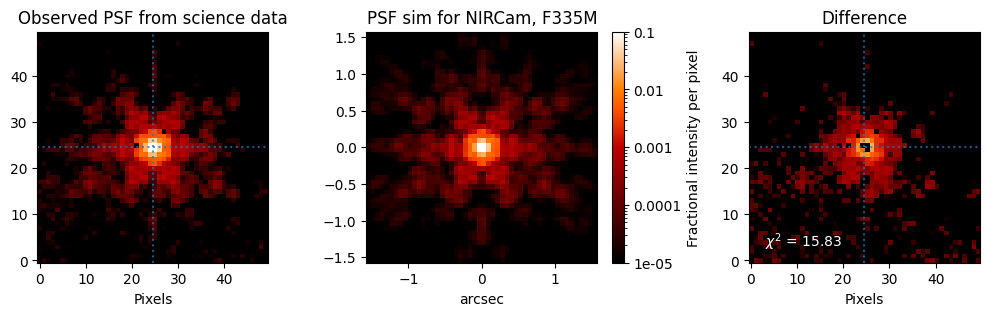

In [14]:
# Plot the data, showing that the PSF fit is slightly improved. 
plot_data_sim_comparison(obs_psf, obs_psf_err, sim_psf_offset)

### Other options to potentially improve fidelity

If further improvements in PSF fidelity are needed, there are additional knobs that can be turned. For example, you may also find it useful to adjust the `.options['charge_diffusion_sigma']` paraneter as well. This provides a (highly simplified!) way to adjust the model to account for charge diffusion from the so-called "brighter fatter effect".  See the docs page about JWST detector effect models for more, or you may choose to consult the JWST help desk for advice on applications to particular science datasets.  This level of precise tuning may not be needed for many science cases. 

Here we show an example of adjusting the charge diffusion model, which is one way to slightly tweak the PSF FWHM to better match a given dataset. 

In [15]:
inst.options['charge_diffusion_sigma'] = 0.028

In [16]:
sim_psf_offset_v2 = inst.calc_psf(fov_pixels=boxsize)

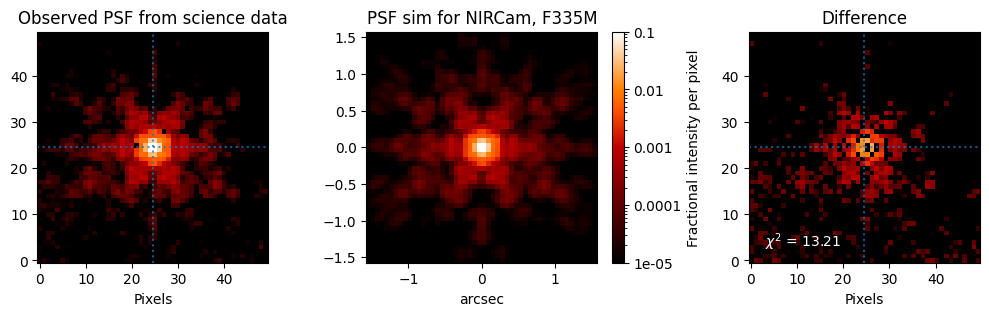

In [17]:
# Plot the data, showing that the PSF fit is again slightly improved. 
plot_data_sim_comparison(obs_psf, obs_psf_err, sim_psf_offset_v2)

## Checking telescope stability around a particular science observation. 

JWST PSFs are in general quite stable over time, though not always. It may be useful to check whether there were significant wavefront variations around the time of a given observation, which can be done with the `show_wfs_around_obs` function. See the [wavefront measurements docs page](https://webbpsf.readthedocs.io/en/latest/jwst_measured_opds.html) for further details.  

In this case, we can verify that the telescope wavefront was stable for the two-day period including that science observation. The delta wavefront error is barely significant:

File jw02739010001_02103_00001_nrcalong_cal.fits observed at 2023-04-05T03:33:47.591
Retrieving WFS before that obs... WFS at 2023-04-03T00:55:44.076
Retrieving WFS after that obs... WFS at 2023-04-05T11:12:18.992


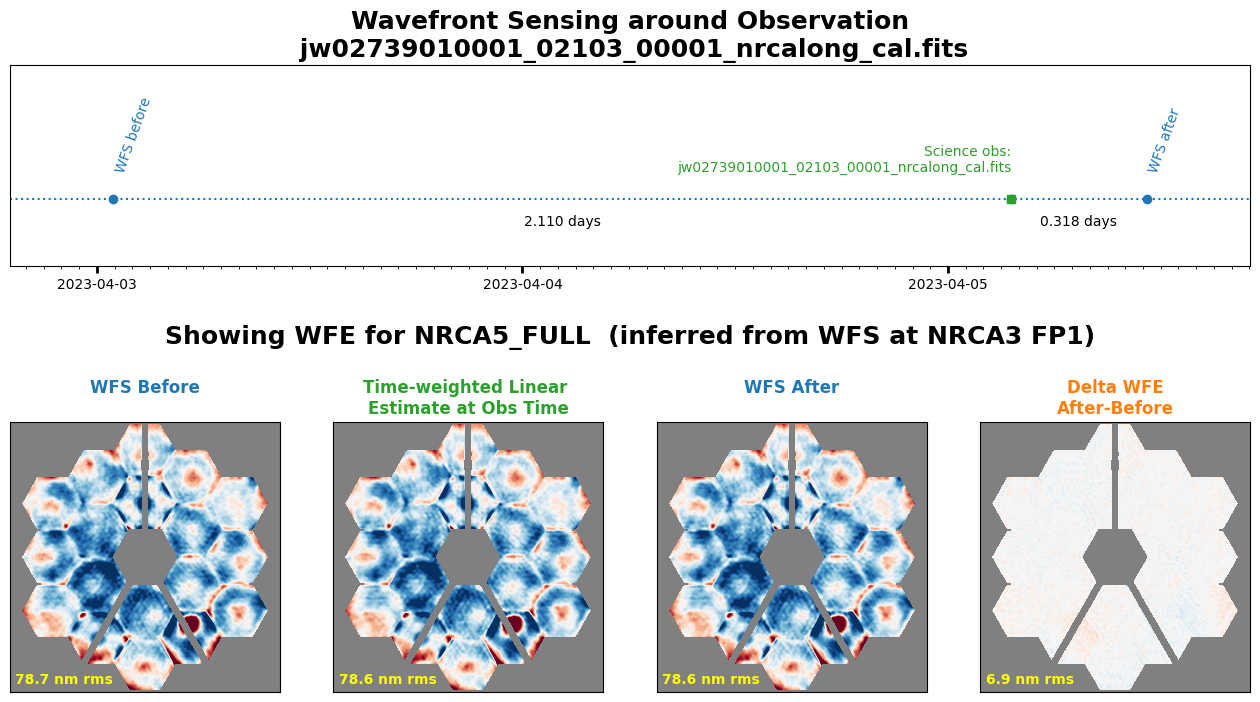

In [18]:
webbpsf.trending.show_wfs_around_obs(filename)